**ASSIGNMENT 4**

1. Group #: 18
   Member Names: Natasha Hussain, Daanish Khan 

   Member Student Numbers: 300122562, 300126840 
   
   Report Title: Classification Empirical Study 

**Derived Datasets**

In [99]:
import spacy
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score, 
    recall_score
)
import matplotlib.pyplot as plt

You have been given a list of datasets in the assignment description. Choose one of the datasets and provide the link below and read the dataset using pandas. You should provide a link to your own Github repository even if you are using a reduced version of a dataset from your TA's repository.

**Dataset:** Airline Passenger Reviews 

**Description:** This dataset provides 64,017 data samples of passenger reviews. They are separated into 3 categories - Passive (Neutral), Detractors (Negative), and Promoters (Positive). The reduced version we will be using contains 10,761 samples. 

Below we have 3 versions of the dataset that we will work with. The first dataset is simply a reduced dataset as we acquired from the source. Our second version of the datase is derived from the first to inlcude only part of speech tags. Our third and last dataset adds onto the second dataset by including part of speech tags as well as named entities. 

In [100]:
#Load the dataset you chose.
url = 'https://raw.githubusercontent.com/NatashaNaima/AI-NLPs/main/reduced_file_AirPassengerReviews.csv'

In [101]:
print(url)
# dataset 1 : the reduced dataset
data = pd.read_csv(url)

https://raw.githubusercontent.com/NatashaNaima/AI-NLPs/main/reduced_file_AirPassengerReviews.csv


In [102]:
data.head()

,customer_review,NPS Score
0,London to Izmir via Istanbul. First time I'd ...,Passive
1,Istanbul to Bucharest. We make our check in i...,Detractor
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor


This is where you create the NLP pipeline. load() will download the correct model (English).

In [103]:
nlp = spacy.load("en_core_web_sm")

Applying the pipeline to every sentences creates a Document where every word is a Token object.

Doc: https://spacy.io/api/doc

Token: https://spacy.io/api/token

In [104]:
#Apply nlp pipeline to the column that has your sentences.
data['tokenized'] = data['customer_review'].apply(nlp)

In [105]:
data.head()

,customer_review,NPS Score,tokenized
0,London to Izmir via Istanbul. First time I'd ...,Passive,"( , London, to, Izmir, via, Istanbul, ., First..."
1,Istanbul to Bucharest. We make our check in i...,Detractor,"( , Istanbul, to, Bucharest, ., We, make, our,..."
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor,"( , Rome, to, Prishtina, via, Istanbul, ., I, ..."
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter,"( , Flew, on, Turkish, Airlines, IAD, -, IST, ..."
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor,"( , Mumbai, to, Dublin, via, Istanbul, ., Neve..."


For our derived datasets, we chose to use only adjectives for POS tagging. Since our datasets were reviews, we believed that adjectives would provide a clear enough picture of the general tone of each review to perform adequate classification. While we did consider doing a mix of tags to increase the amount of data we would have to work with, we believed in the end it would add more noise.

In [106]:
#create empty dataframes that will store derived datasets

derived_dataset1 = pd.DataFrame(columns = ['Class', 'pos'])
derived_dataset2 = pd.DataFrame(columns = ['Class', 'pos-np'])

In [107]:
def get_pos(sentence, wanted_pos): #wanted_pos refers to the desired pos tagging
    verbs = []
    for token in sentence:
        if token.pos_ in wanted_pos:
            verbs.append(token.lemma_) # lemma returns a number. lemma_ return a string
    return ' '.join(verbs) # return value is as a string and not a list for countVectorizer

In [108]:
derived_dataset1['pos'] = data['tokenized'].apply(lambda sent : get_pos(sent, ['ADJ']))
derived_dataset1['Class'] = data['NPS Score']

In [109]:
derived_dataset1.head(10)

,Class,pos
0,Passive,first good nice great Most contradictory littl...
1,Detractor,first last
2,Detractor,several past bad bad normal most useless few w...
3,Promoter,excellent inflight extensive easy excellent in...
4,Detractor,turkish other more
5,Detractor,stuck rude slow unhelpful only only positive g...
6,Detractor,same technical complete armed civilian total m...
7,Detractor,unfriendly
8,Passive,comfortable small okay mid okay great friendly...
9,Detractor,devastating final final turkish much unhelpful...


In [110]:
def get_entities(sentence, wanted_entities):
    entity = []
    for ent in sentence.ents:
        if ent.label_ in wanted_entities:
            entity.append(ent.text)
            
    return ' '.join(entity) 

For our second dataset, we included 3 named entities : organizations (airlines) and locations (travel destinations). These types of entities are relevant for classification as different airlines are known to meet certain levels of quality and different flights across airports experience varying levels of logistical consistency that affect flyers' experiences. 

In [111]:
derived_dataset2['ent-np'] = data['tokenized'].apply(lambda sent : get_entities(sent, ['ORG', 'GPE']))
derived_dataset2['pos-np'] = data['tokenized'].apply(lambda sent : get_pos(sent, ['ADJ']))
derived_dataset2['Class'] = data['NPS Score']
derived_dataset2.head(10)

,Class,pos-np,ent-np
0,Passive,first good nice great Most contradictory littl...,London Istanbul LHR Istanbul Ukraine London Is...
1,Detractor,first last,Istanbul
2,Detractor,several past bad bad normal most useless few w...,Rome Prishtina Istanbul Rome Prishtina Istanbu...
3,Promoter,excellent inflight extensive easy excellent in...,Turkish Airlines Turkish Airlines Turkish Airl...
4,Detractor,turkish other more,Mumbai Dublin Istanbul Dublin Mumbai Mumbai Is...
5,Detractor,stuck rude slow unhelpful only only positive g...,Istanbul Budapest Dublin Turkish Airlines Ista...
6,Detractor,same technical complete armed civilian total m...,Istanbul Algiers Algiers Algiers Turkish Airlines
7,Detractor,unfriendly,Basel Cape Town Istanbul Istanbul Burger King
8,Passive,comfortable small okay mid okay great friendly...,Abu Dhabi Luxembourg Istanbul AUH-IST AUH
9,Detractor,devastating final final turkish much unhelpful...,Turkish Airlines Turkish Airlines JetBlue Veni...


Now that we have our derived datasets, we can move to perform our classificaton task.

**Perform Classification Task**

### Encoding

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

dataset_tfidf = TfidfVectorizer().fit_transform(data.customer_review)
derived_dataset_1_tfidf = TfidfVectorizer().fit_transform(derived_dataset1.pos)
derived_dataset_2_tfidf = TfidfVectorizer().fit_transform(derived_dataset2['pos-np'].to_numpy() + derived_dataset2['ent-np'])

## Logistical Regression Model

Logistical regression estimates the probability of an outcome using a logistic function. The model is trained to find the optimal parameters in our dataset to maximize the likelihood of a particular review, and it provides a decision boundary for classification.

To start we set out with mostly default parameters for logistical regression:

We set our maximum interations to 1000 so that if convergence doesn't occur before then, our function will not take to long to run.

We start here with C=1 to have a moderate regularization. Regularization is a technique used to prevent overfitting. A smaller C value specifies strong regularization, while a larger involves weaker regularization. 

We used Limited-memory Broyden–Fletcher–Goldfarb–Shanno ('lbfgs') for our optimization algorithm. Logistic regression can be solved using different optimization algorithms. Different solvers have different characteristics that perform better or worse dependant on the dataset size, features, and other factors. We chose LM BFGS because it is a popular choice for logistical regression on small to medium sized datasets.

In [113]:
def logistical_regression(x_train, x_test, y_train, y_test, C=1, solver='lbfgs'):
	model = LogisticRegression(max_iter=1000, C=1, solver='lbfgs').fit(x_train, y_train)

	# Make prediction from model
	y_pred = model.predict(x_test)

	# calculate accuracy and f1
	accuracy = accuracy_score(y_pred, y_test)
	f1 = f1_score(y_pred, y_test, average="weighted")

	# calculating micro and macro precision/recall
	micro_precision = precision_score(y_test, y_pred, average="micro", zero_division=0)
	micro_recall = recall_score(y_test, y_pred, average="micro", zero_division=0)

	# calculating macro precision/recall 
	macro_precision = precision_score(y_test, y_pred, average="macro", zero_division=0)
	macro_recall = recall_score(y_test, y_pred, average="macro", zero_division=0)

	evaluation = {'accuracy': accuracy, 'f1': f1, 'macro_p': macro_precision, 'macro_r':macro_recall, 'micro_p':micro_precision, 'micro_r': micro_recall}
	return model, y_pred, evaluation

## MLP Model

An MLP classification refers to the use of a Multi-Layer Perceptron for solving classification problems. They are known for their ability to capture complex relationships in data and perform well on a variety of tasks. However, they may require more data and computational resources compared to simpler models, and proper tuning of parameters is crucial for achieving good results.

To start, we used the default parameters to classify our dataset. There are many paramters that can be changed and fine-tuned, but some notable ones to discuss here are:

Hidden layer sizes: This paramter determines the number of neurons in each hidden layer. The default, that we use, is 100. 

Solver : The optimization algorithm used for weight opitmization. The default, that we use, is adam.

Maximum iterations : The number of iterations for the solver to converge. When the model is not converging, we would set this to be very high so that we can choose a time to force it to converge. The default, that we use, is 200.

In [114]:
from sklearn.neural_network import MLPClassifier

def mlp(x_train, x_test, y_train, y_test, max_iter='200', solver='adam', hidden_layer_sizes='(100,)'):
	model = MLPClassifier().fit(x_train, y_train)

	# Make prediction from model
	y_pred = model.predict(x_test)

	# calculate accuracy and f1
	accuracy = accuracy_score(y_pred, y_test)
	f1 = f1_score(y_pred, y_test, average="weighted")

	# calculating micro and macro precision/recall
	micro_precision = precision_score(y_test, y_pred, average="micro", zero_division=0)
	micro_recall = recall_score(y_test, y_pred, average="micro", zero_division=0)

	# calculating macro precision/recall 
	macro_precision = precision_score(y_test, y_pred, average="macro", zero_division=0)
	macro_recall = recall_score(y_test, y_pred, average="macro", zero_division=0)

	evaluation = {'accuracy': accuracy, 'f1': f1, 'macro_p': macro_precision, 'macro_r':macro_recall, 'micro_p':micro_precision, 'micro_r': micro_recall}
	return model, y_pred, evaluation

## Evaluation

### Default Parameters

In [115]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=4)
dataset_results_LR = []
derived_dataset_1_results_LR = []
derived_dataset_2_results_LR = []

dataset_results_MLP = []
derived_dataset_1_results_MLP = []
derived_dataset_2_results_MLP = []

def kfold_eval(dataset, target):
	resultsLR = []
	resultsMLP = []
	for train_index, test_index in kf.split(dataset):
		x_train, x_test, y_train, y_test = dataset[train_index], dataset[test_index], target[train_index], target[test_index]

		_, _, results_LR = logistical_regression(x_train, x_test, y_train, y_test)

		_, _, results_MLP = mlp(x_train, x_test, y_train, y_test)

		resultsLR.append(results_LR)
		resultsMLP.append(results_MLP)
	
	return resultsLR, resultsMLP

dataset_results_LR, dataset_results_MLP = kfold_eval(dataset_tfidf, data['NPS Score'])
derived_dataset_1_results_LR, derived_dataset_1_results_MLP = kfold_eval(derived_dataset_1_tfidf, derived_dataset1['Class'])
derived_dataset_2_results_LR, derived_dataset_2_results_MLP = kfold_eval(derived_dataset_2_tfidf, derived_dataset2['Class'])

dataset_results_LR_avg = {metric: sum(result[metric] for result in dataset_results_LR) / len(dataset_results_LR) for metric in dataset_results_LR[0]}
derived_dataset_1_LR_avg = {metric: sum(result[metric] for result in derived_dataset_1_results_LR) / len(derived_dataset_1_results_LR) for metric in derived_dataset_1_results_LR[0]}
derived_dataset_2_LR_avg = {metric: sum(result[metric] for result in derived_dataset_2_results_LR) / len(derived_dataset_2_results_LR) for metric in derived_dataset_2_results_LR[0]}

dataset_results_MLP_avg = {metric: sum(result[metric] for result in dataset_results_MLP) / len(dataset_results_MLP) for metric in dataset_results_MLP[0]}
derived_dataset_1_MLP_avg = {metric: sum(result[metric] for result in derived_dataset_1_results_MLP) / len(derived_dataset_1_results_MLP) for metric in derived_dataset_1_results_MLP[0]}
derived_dataset_2_MLP_avg = {metric: sum(result[metric] for result in derived_dataset_2_results_MLP) / len(derived_dataset_2_results_MLP) for metric in derived_dataset_2_results_MLP[0]}

print("Average Results for Logistic Regression With Default Params (Original Dataset):")
for metric, value in dataset_results_LR_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for Logistic Regression With Default Params (Derived Dataset 1):")
for metric, value in derived_dataset_1_LR_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for Logistic Regression With Default Params (Derived Dataset 2):")
for metric, value in derived_dataset_2_LR_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for MLP With Default Params (Original Dataset):")
for metric, value in dataset_results_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for MLP With Default Params (Derived Dataset 1):")
for metric, value in derived_dataset_1_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for MLP With Default Params (Derived Dataset 2):")
for metric, value in derived_dataset_2_MLP_avg.items():
	print(f"{metric}: {value:.4f}")


/home/natasha/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/natasha/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/natasha/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/natasha/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Average Results for Logistic Regression With Default Params (Original Dataset):
accuracy: 0.7877
f1: 0.8102
macro_p: 0.6972
macro_r: 0.6698
micro_p: 0.7877
micro_r: 0.7877

Average Results for Logistic Regression With Default Params (Derived Dataset 1):
accuracy: 0.7634
f1: 0.7918
macro_p: 0.6568
macro_r: 0.6399
micro_p: 0.7634
micro_r: 0.7634

Average Results for Logistic Regression With Default Params (Derived Dataset 2):
accuracy: 0.7515
f1: 0.7827
macro_p: 0.6530
macro_r: 0.6212
micro_p: 0.7515
micro_r: 0.7515

Average Results for MLP With Default Params (Original Dataset):
accuracy: 0.7570
f1: 0.7611
macro_p: 0.6605
macro_r: 0.6640
micro_p: 0.7570
micro_r: 0.7570

Average Results for MLP With Default Params (Derived Dataset 1):
accuracy: 0.6883
f1: 0.6899
macro_p: 0.5859
macro_r: 0.5990
micro_p: 0.6883
micro_r: 0.6883

Average Results for MLP With Default Params (Derived Dataset 2):
accuracy: 0.6653
f1: 0.6633
macro_p: 0.5720
macro_r: 0.5777
micro_p: 0.6653
micro_r: 0.6653


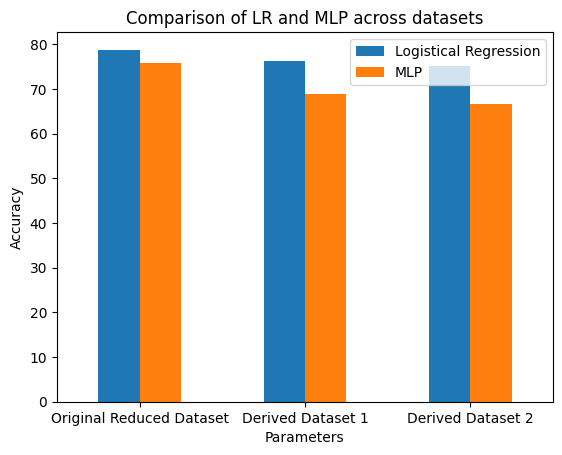

In [116]:


LR = [dataset_results_LR_avg.get('accuracy', None) *100, derived_dataset_1_LR_avg.get('accuracy', None) *100, derived_dataset_2_LR_avg.get('accuracy', None) *100]
MLP = [dataset_results_MLP_avg.get('accuracy', None)*100, derived_dataset_1_MLP_avg.get('accuracy', None)*100,derived_dataset_2_MLP_avg.get('accuracy', None)*100] 
index = ['Original Reduced Dataset', 'Derived Dataset 1','Derived Dataset 2']

df = pd.DataFrame(
    {
        'Logistical Regression' : LR,
        'MLP' : MLP
    },
    index=index
)
ax = df.plot.bar(rot=0, xlabel='Parameters', ylabel='Accuracy', title='Comparison of LR and MLP across datasets')

For both models, the original dataset provides most accurancy, first derived dataset with only POS performing notably worse and the second derived dataset worse still; across all datasets, logistical regression is consistently more accurate while MLP lags behind further and further with each dataset.

Logistical Regression performs beter on smaller datasets. Our dataset has over 10 000 samples, which a lot compared to previous sets used for logistical regression in this class, is still relatively small when compared to the extremely large datasets that models like MLP were developed for. Additionally, we used only the default parameters of MLP. MLP has many parameters that can be finely tuned to increase accuracy based on the conditions our dataset is in.

The first dataset contains pure raw text information from each review. This provides more features to associate with each result. Given the difference between the original dataset and the first derivation (-2% for LR and -6% for MLP) we believe there is lies other features in the raw text not included in adjectives nor our entities that increases the accuracy of these models. 

We also see that micro precision/recall perform better than our macro precision and recall. This shows us that our model is relying on larger classes to classify. In our case where we are purely looking out for what features result in good or bad reviews, this might actually be preferrable as it gives us an insight into certain qualities of the larger dataset.

### Parameter Changes for MLP

#### First Change
In our first modification to MLP, since our logistical regression outperformed our default MLP, we want to change our parameters to as closely match the process of our logistical regresion model. So we set our maximum interations to 1000 and use Limited-memory Broyden–Fletcher–Goldfarb–Shanno ('lbfgs') for our optimization algorithm. 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=4)
dataset_results_MLP = []
derived_dataset_1_results_MLP = []
derived_dataset_2_results_MLP = []

def kfold_eval(dataset, target):
	resultsMLP = []
	for train_index, test_index in kf.split(dataset):
		x_train, x_test, y_train, y_test = dataset[train_index], dataset[test_index], target[train_index], target[test_index]

		_, _, results_MLP = mlp(x_train, x_test, y_train, y_test,max_iter='1000', solver='lbfgs')

		resultsMLP.append(results_MLP)
	
	return resultsLR, resultsMLP

dataset_results_MLP = kfold_eval(dataset_tfidf, data['NPS Score'])
derived_dataset_1_results_MLP = kfold_eval(derived_dataset_1_tfidf, derived_dataset1['Class'])
derived_dataset_2_results_MLP = kfold_eval(derived_dataset_2_tfidf, derived_dataset2['Class'])

dataset_results_MLP_avg = {metric: sum(result[metric] for result in dataset_results_MLP) / len(dataset_results_MLP) for metric in dataset_results_MLP[0]}
derived_dataset_1_MLP_avg = {metric: sum(result[metric] for result in derived_dataset_1_results_MLP) / len(derived_dataset_1_results_MLP) for metric in derived_dataset_1_results_MLP[0]}
derived_dataset_2_MLP_avg = {metric: sum(result[metric] for result in derived_dataset_2_results_MLP) / len(derived_dataset_2_results_MLP) for metric in derived_dataset_2_results_MLP[0]}

print("\nAverage Results for MLP With Default Params (Original Dataset):")
for metric, value in dataset_results_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for MLP With Default Params (Derived Dataset 1):")
for metric, value in derived_dataset_1_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for MLP With Default Params (Derived Dataset 2):")
for metric, value in derived_dataset_2_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

The result of these parameter changes is that we see results closer to those of logistic regression. Still, their accuracy is worse

#### Second Change
In our second attempt at fine-tuning MLP to be better, we will increase the hidden layer size. Increasing the hidden layer size increases the model's capacity to learn from the data, however, too much can result in overfitting. We will evaluate whether this occurs by keeping track of our micro and macro precision/recall measure.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=4)
dataset_results_MLP = []
derived_dataset_1_results_MLP = []
derived_dataset_2_results_MLP = []

def kfold_eval(dataset, target):
	resultsMLP = []
	for train_index, test_index in kf.split(dataset):
		x_train, x_test, y_train, y_test = dataset[train_index], dataset[test_index], target[train_index], target[test_index]

		_, _, results_MLP = mlp(x_train, x_test, y_train, y_test,hidden_layer_sizes='(200,)')

		resultsMLP.append(results_MLP)
	
	return resultsMLP

dataset_results_MLP = kfold_eval(dataset_tfidf, data['NPS Score'])
derived_dataset_1_results_MLP = kfold_eval(derived_dataset_1_tfidf, derived_dataset1['Class'])
derived_dataset_2_results_MLP = kfold_eval(derived_dataset_2_tfidf, derived_dataset2['Class'])

dataset_results_MLP_avg = {metric: sum(result[metric] for result in dataset_results_MLP) / len(dataset_results_MLP) for metric in dataset_results_MLP[0]}
derived_dataset_1_MLP_avg = {metric: sum(result[metric] for result in derived_dataset_1_results_MLP) / len(derived_dataset_1_results_MLP) for metric in derived_dataset_1_results_MLP[0]}
derived_dataset_2_MLP_avg = {metric: sum(result[metric] for result in derived_dataset_2_results_MLP) / len(derived_dataset_2_results_MLP) for metric in derived_dataset_2_results_MLP[0]}

print("\nAverage Results for MLP With Default Params (Original Dataset):")
for metric, value in dataset_results_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for MLP With Default Params (Derived Dataset 1):")
for metric, value in derived_dataset_1_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

print("\nAverage Results for MLP With Default Params (Derived Dataset 2):")
for metric, value in derived_dataset_2_MLP_avg.items():
	print(f"{metric}: {value:.4f}")

### Analysis

### References
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html